In [105]:
from predict import *

from tf_keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

In [106]:
def bool_to_annotations(y, fps =30):
    """Generates start and stop time in seconds for a boolean array

    Args:
        y (numpy.ndarray): boolean array indicating frames with scratching
        fps (int, optional): frame rate

    Returns:
        list: list of starts, stops for each bout of scratching in boolean array
    """
    y = np.insert(y, 0,0)
    starts = np.where(np.diff(y) == 1)[0] 
    stops = np.where(np.diff(y)== -1)[0] 

    seconds = np.linspace(0, len(y)/fps, len(y))
    st = seconds[starts]
    sto = seconds[stops]
    tc2 = [[s1, s2] for s1,s2 in zip(st,sto)]
    return tc2

In [107]:
def format_annotations(anns, start = 0, length = 30, bin_size = 5):
    
    n_bins = int(length/bin_size)
    all_bouts = []
    all_durations = []
    for s in range(n_bins):
        start_sec = (s * bin_size * 60) + (start * 60)
        end_sec = start_sec + (bin_size * 60)

        for a in anns:
            duration = 0
            bouts = 0
            for a in anns:
                b = (a >= start_sec) & (a <= end_sec)
                if b[0] & b[1]:
                    duration = duration + (a[1] - a[0])
                    bouts = bouts + 1
                if b[1] & ~b[0]:
                    duration = duration +(a[1] - start_sec)
                    bouts = bouts + 1
                if b[0] & ~b[1]:
                    duration = duration +(end_sec - a[0])
                    bouts = bouts + 1
        
        all_bouts.append(bouts)
        all_durations.append(duration)

    return all_durations, all_bouts

In [4]:
# model = load_movinet_model(checkpoint_path="/Users/rebeccakrall/Code/Multiclass_Behavioral_Classification/Models/scratch_101724/cp_00.ckpt" )

In [108]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

# model = movinet_model.MovinetClassifier(
#     backbone,
#     num_classes=1,
#     output_states=True)

# # Create your example input here.
# # Refer to the paper for recommended input shapes.
# inputs = tf.ones([8, 30, 172, 172, 3]) #(8, 8, 224, 224, 3)

# # [Optional] Build the model and load a pretrained checkpoint.
# model.build(inputs.shape)





# load previous checkpoing
# checkpoint_dir = 'binary_model'
# checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint = tf.train.Checkpoint(model=model)
# status = checkpoint.restore(checkpoint_path)
# status.assert_existing_objects_matched()

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)


def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model


batch_size = 8
num_frames = 30
# Construct loss, optimizer and compile the model
with distribution_strategy.scope():
  model = build_classifier(batch_size, num_frames, resolution, backbone, 1)
  loss_obj =  BinaryCrossentropy(from_logits=True)
  optimizer = tf_keras.optimizers.legacy.Adam(learning_rate = 0.001)
  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

checkpoint_dir = "/Users/rebeccakrall/Code/Multiclass_Behavioral_Classification/Models/scratch_121824"
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

2025-01-15 13:11:50.075565: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-01-15 13:11:50.075877: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-15 13:11:50.075896: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-15 13:11:50.076366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-15 13:11:50.076544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [6]:
# video_path = "/Users/rebeccakrall/Data/Video Processing and Prediction/Scratching_Projects/PRX_03/PRX_03_Videos/PRX-03_Run_3_Computer_1_D8_Males_12DEC22.mp4"
# 

In [10]:
video_path = "/Users/rebeccakrall/Data/Video Processing and Prediction/Scratching_Projects/PRX_03/PRX_03_Videos/PRX_03_Run_1_Computer_1_D12_Males_16DEC22clip_2.mp4"

output_signature = (tf.TensorSpec(shape = (None, None, None, None, 3), dtype = tf.float32))


predict_ds = tf.data.Dataset.from_generator(VidGenerator(video_path, n_frames = 20, frame_step = 1, buffer = 300, output_size = (172,172), animal_choice = 'm6', 
                                                         start = 0, stop = 1800),
                                            output_signature = output_signature)

# predict_ds = predict_ds.batch(8)



/Users/rebeccakrall/Code/Multiclass_Behavioral_Classification/video_preprocessing.py:233: RuntimeWarning: Mean of empty slice
  dis = np.nanmean(x_displace[start::3])


In [11]:
a = model.predict(predict_ds, batch_size = 256)

opened cap
     90/Unknown - 113s 965ms/step

2025-01-07 15:45:46.375812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-07 15:45:46.375844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-07 15:45:46.375861: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16106587468826726925
2025-01-07 15:45:46.375866: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2201015744223834791
2025-01-07 15:45:46.375870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11892870399051756232
2025-01-07 15:45:46.375877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8386689478797288257
2025-01-0

90/90 [==============================] - 114s 979ms/step


In [70]:
bool_to_annotations(np.array(a < 0).astype(int), fps = 1.5)

[[0.0, 3.3703703703703702], [45.162962962962965, 47.85925925925926]]

In [110]:
import pandas as pd

In [189]:
ref = pd.read_csv("/Users/rebeccakrall/Desktop/MoviNet Scratch Model Tests/some_manual_scores_prx03.csv")

In [112]:
vid_directory = "/Users/rebeccakrall/Data/Video Processing and Prediction/Scratching_Projects/PRX_03/PRX_03_Videos"
ref = pd.read_csv("/Users/rebeccakrall/Desktop/MoviNet Scratch Model Tests/some_manual_scores_prx03.csv")

output_signature = (tf.TensorSpec(shape = (None, None, None, None, 3), dtype = tf.float32))
fps =  30


In [119]:
# single vid test
ind = 7
mouse_id = ref.loc[ind, 'mouse id']
fp = os.path.join(vid_directory, ref.loc[ind, 'filepath'])
# start_ind = ref.loc[ind, 'Video Start Time'] * 60 * fps
# end_ind = ref.loc[ind, 'Video End Time'] * 60 * fps
start_ind = 0 * 60 * fps
end_ind= 5 * 60 * fps

predict_ds = tf.data.Dataset.from_generator(VidGenerator(fp, n_frames = 20, frame_step = 1, buffer = 300, output_size = (172,172), animal_choice = mouse_id, 
                                                         start = start_ind, stop = end_ind),
                                            output_signature = output_signature)

a = model.predict(predict_ds, batch_size = 256)


opened cap
    450/Unknown - 468s 1s/step

2025-01-15 13:30:58.802907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-15 13:30:58.802929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[movinet_classifier/movinet/block4_layer2/bneck/se/global_average_pool3d_13/Cumsum/_114]]
2025-01-15 13:30:58.802935: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4082223203863552271
2025-01-15 13:30:58.802939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3094463015911572063
2025-01-15 13:30:58.802943: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7116168882887140051
2025-01-15 13:30:58.802946: I tensorflow/core/framework/local_rendezvous.cc:422] Local rende

450/450 [==============================] - 468s 1s/step


In [134]:
ann = bool_to_annotations(np.array(a < 0).astype(int), fps = 2/3)
# tot = sum((a < 0))

In [124]:
ann

[[1.3362962962962963, 2.6725925925925926],
 [114.25333333333333, 114.92148148148148],
 [118.93037037037037, 119.59851851851852],
 [120.93481481481481, 124.27555555555556],
 [130.2888888888889, 132.29333333333332],
 [168.37333333333333, 169.0414814814815],
 [174.38666666666666, 178.39555555555555],
 [179.73185185185184, 180.4],
 [181.7362962962963, 182.40444444444444],
 [184.4088888888889, 185.07703703703703],
 [185.7451851851852, 188.4177777777778],
 [218.48444444444445, 220.48888888888888],
 [242.5377777777778, 247.21481481481482],
 [256.56888888888886, 257.9051851851852],
 [261.91407407407405, 265.25481481481484],
 [287.97185185185185, 290.64444444444445],
 [296.65777777777777, 297.32592592592596]]

In [125]:
297/60

4.95

In [13]:
duration, bouts =  format_annotations(np.array(ann))

In [14]:
duration

[42.68246913580237,
 27.121234567901126,
 27.565679012345754,
 22.67506172839512,
 18.00666666666666,
 2.6676543209875945]

In [ ]:
logits = {}
anns = {}
for ind, row in ref.iterrows():
    print(f"analyzing {row['filepath']}")
    mouse_id = row['mouse id']
    fp = os.path.join(vid_directory, row['filepath'])
    start_ind = row['Video Start Time'] * 60 * fps
    end_ind = row['Video End Time'] * 60 * fps
    predict_ds = tf.data.Dataset.from_generator(VidGenerator(fp, n_frames = 30, frame_step = 1, buffer = 300, output_size = (172,172), animal_choice = mouse_id, 
                                                         start = start_ind, stop = end_ind),
                                            output_signature = output_signature)
    
    a = model.predict(predict_ds, batch_size = 256)
    ann = bool_to_annotations(np.array(a < 0).astype(int), fps = 1.5)

    logits[ind] = a
    anns[ind] = ann

In [190]:
with open("/Users/rebeccakrall/Desktop/MoviNet Scratch Model Tests/Fourth round/logits5.pkl", 'rb') as file:
    logits = pickle.load(file)

In [191]:
anns = {}
for k,v in logits.items():
    logs = np.array([[x] * 20 for x in np.array(v < 0).astype(int)]).flatten()
    ann = bool_to_annotations(logs, fps = 24)
    anns[k] = ann

In [15]:
with open("/Users/rebeccakrall/Desktop/anns5.pkl", "wb") as file:
    pickle.dump(anns, file)

In [192]:
total = {}
for k,v in logits.items():
    total[k] = sum((v < 0) * (2/3))


In [193]:
ref['model_count'] = [x[0] for x  in total.values()]

In [194]:
ref['dif'] = ref['model_count'] - ref['Total Time']

In [195]:
ref.sort_values(by = 'dif')

,Unnamed: 0,filepath,mouse id,Video,Subject #,Scorer,Video Start Time,Video End Time,0-5,10-May,15-Oct,15-20,20-25,25-30,Total Time,model_count,dif
60,60,PRX_03_Run_4_Computer_1_D12_females_19DEC22.mp4,m1,D12_Female_Run 4_Comp 1 (F85-90),89,Jonathan,8,38,15.48,14.76,17.02,9.47,11.53,74.94,143.20,96.000000,-47.200000
20,20,PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4,m4,D12_Male_Run 3_Comp 1 (m25-30),30,Josh,10,40,29.59,54.94,57.19,66.33,33.88,11.94,253.87,222.000000,-31.870000
5,5,PRX_03_Run_3_Computer_2_D8_Males_12DEC22.mp4,m3,D8_Male_Run 3_Comp 2 (m31-36),31,Bob,0,30,18.68,20.94,39.89,59.28,26.26,0.00,165.05,138.000000,-27.050000
56,56,PRX_03_Run_3_Computer_2_D12_females_19DEC22.mp4,m2,D12_Female_Run 3_Comp 2 (F79-84),81,Jonathan,4,34,0.00,0.00,37.48,0.00,0.00,0.00,37.48,24.000000,-13.480000
27,27,PRX_03_Run_4_Computer_2_D12_Males_16DEC22.mp4,m6,D12_Male_Run 4_Comp 2 (m43-48),44,Faizan,2,32,31.78,25.03,50.09,0.00,0.00,0.00,106.90,95.333333,-11.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2,PRX-03_Run_3_Computer_1_D8_Males_12DEC22.mp4,m5,D8_Male_Run 3_Comp 1 (m25-30),28,Bob,6,36,42.98,12.94,25.65,1.85,12.53,55.99,151.94,226.000000,74.060000
17,17,PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4,m6,D12_Male_Run 3_Comp 1 (m25-30),26,Bob,2,32,23.30,21.04,35.92,33.04,0.00,17.40,130.70,209.333333,78.633333
7,7,PRX_03_Run_3_Computer_2_D8_Males_12DEC22.mp4,m2,D8_Male_Run 3_Comp 2 (m31-36),33,Bob,4,34,25.06,23.62,24.54,0.75,40.11,74.18,188.26,272.666667,84.406667
23,23,PRX_03_Run_3_Computer_2_D12_Males_16DEC22.mp4,m2,D12_Male_Run 3_Comp 2 (m31-36),33,Richard,4,34,34.43,36.76,6.03,29.17,2.53,9.63,118.55,204.000000,85.450000


In [196]:
format_ann = [f'{int(x//60)}:{int(x%60)}, {int(y//60)}:{int(y%60)} ' for x, y in np.array(anns[60]) + (8*60)]

In [168]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
smoo = np.convolve(np.squeeze(logits[60]), kernel, mode='same')

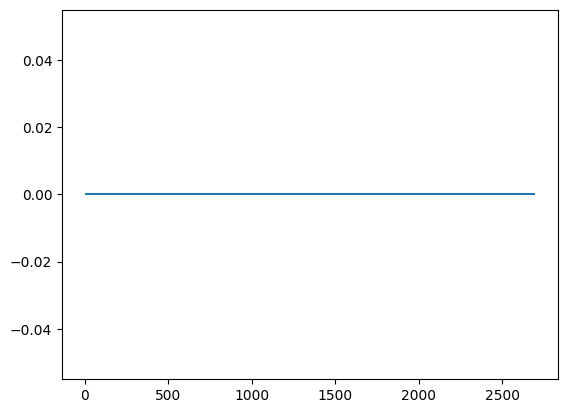

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.plot(logits[60][0:])
# plt.plot(smoo)
plt.hlines(0, 0, len(logits[0]))
plt.show()

In [12]:
def format_annotations(anns, start = 0, length = 30, bin_size = 5):
    
    n_bins = int(length/bin_size)
    all_bouts = []
    all_durations = []
    for s in range(n_bins):
        start_sec = (s * bin_size * 60) + (start * 60)
        end_sec = start_sec + (bin_size * 60)

        
        duration = 0
        bouts = 0
        for a in anns:
            b = (a >= start_sec) & (a <= end_sec)
            if b[0] & b[1]:
                duration = duration + (a[1] - a[0])
                bouts = bouts + 1
            if b[1] & ~b[0]:
                duration = duration +(a[1] - start_sec)
                bouts = bouts + 1
            if b[0] & ~b[1]:
                duration = duration +(end_sec - a[0])
                bouts = bouts + 1
        
        all_bouts.append(bouts)
        all_durations.append(duration)

    return all_durations, all_bouts

In [197]:
all_dur = []
for k,v in anns.items():
    duration, bouts =  format_annotations(np.array(v))
    all_dur.append(duration)

ad = np.array(all_dur)

In [91]:
ann = bool_to_annotations(np.array(a < 0).astype(int), fps = 0.5)
format_annotations(np.array(ann))

([16.017777777777788,
  14.01555555555558,
  8.008888888888805,
  2.0022222222221444,
  0,
  8.008888888888805],
 [3, 1, 3, 1, 0, 3])

In [90]:
len(a)

900

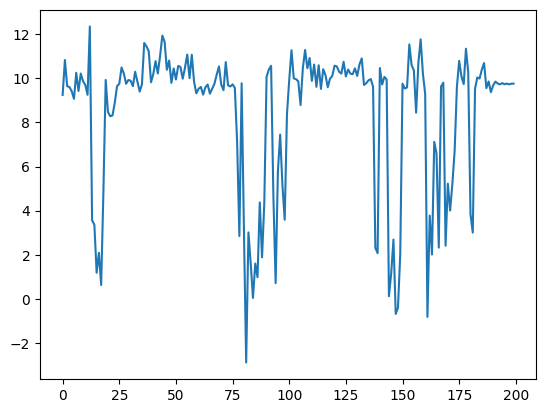

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(a[700:])
plt.show()

In [198]:
ref['first_bin'] = ad[:,0]
ref['second_bin'] = ad[:,1]
ref['third_bin'] = ad[:,2]
ref['fourth_bin'] = ad[:,3]
ref['fifth_bin'] = ad[:,4]
ref['sixth_bin'] = ad[:,5]

In [199]:
ref['dif_first'] = ref['0-5'] - ref['first_bin']
ref['dif_second'] = ref['10-May'] - ref['second_bin']
ref['dif_third'] = ref['15-Oct'] - ref['third_bin']
ref['dif_fourth'] = ref['15-20'] - ref['fourth_bin']
ref['dif_fifth'] = ref['20-25'] - ref['fifth_bin']
ref['dif_sixth'] = ref['25-30'] - ref['sixth_bin']

In [200]:
ref.to_csv("/Users/rebeccakrall/Desktop/scratch_120624_cp03_manual_scores_prx03_redo.csv")

In [199]:
format_ann = [f'{int(x//60)}:{int(x%60)}, {int(y//60)}:{int(y%60)} ' for x, y in np.array(ann2) + (8*60)]
format_ann

['8:16, 8:16 ',
 '8:24, 8:25 ',
 '8:28, 8:28 ',
 '8:29, 8:30 ',
 '8:43, 8:44 ',
 '8:50, 8:50 ',
 '8:52, 8:54 ',
 '8:55, 8:58 ',
 '9:1, 9:8 ',
 '10:13, 10:14 ',
 '10:15, 10:16 ',
 '10:34, 10:34 ',
 '10:43, 10:44 ',
 '10:46, 10:47 ',
 '10:52, 10:52 ',
 '10:55, 10:56 ',
 '11:8, 11:9 ',
 '11:13, 11:14 ',
 '11:18, 11:19 ',
 '11:20, 11:21 ',
 '11:38, 11:38 ',
 '11:47, 11:48 ',
 '11:50, 11:52 ',
 '11:54, 11:54 ',
 '11:56, 11:56 ',
 '11:58, 12:0 ',
 '12:1, 12:2 ',
 '12:7, 12:9 ',
 '12:15, 12:16 ',
 '12:26, 12:28 ',
 '12:34, 12:35 ',
 '13:2, 13:3 ',
 '13:14, 13:15 ',
 '13:28, 13:32 ',
 '13:33, 13:34 ',
 '13:35, 13:38 ',
 '13:39, 13:43 ',
 '14:6, 14:7 ',
 '14:11, 14:12 ',
 '14:14, 14:15 ',
 '14:35, 14:36 ',
 '17:9, 17:10 ',
 '18:12, 18:14 ',
 '18:14, 18:17 ',
 '18:18, 18:20 ',
 '18:24, 18:24 ',
 '18:27, 18:28 ',
 '18:34, 18:40 ',
 '18:40, 18:41 ',
 '18:42, 18:44 ',
 '19:24, 19:24 ',
 '19:40, 19:41 ',
 '19:53, 19:54 ',
 '20:36, 20:37 ',
 '20:38, 20:38 ',
 '20:53, 20:54 ',
 '22:31, 22:32 ',
 '22:4

In [263]:
fps = 30 
clip_length = 60
total_frames = 9000

clip_starts = [100, 4623]

In [264]:
new_start = random.randint(0, total_frames - (fps*clip_length))

In [269]:
upper = new_start 
end1 = new_start + (fps*clip_length)

In [274]:
any([ ((new_start + (fps*clip_length)) <= x) or ((x + (fps*clip_length)) <= new_start) for x in clip_starts])

True

In [275]:
new_start

6299

In [276]:
4923 + (fps*clip_length)

6723

In [1]:
import pickle

In [5]:
# with open("/Users/rebeccakrall/Desktop/anns5.pkl", "wb") as file:
with open("/Users/rebeccakrall/Desktop/MoviNet Scratch Model Tests/Fourth round/anns4.pkl", 'rb') as file:
    anns = pickle.load(file)

In [4]:
logits

{0: array([[ 9.929771],
        [ 9.839922],
        [11.059437],
        ...,
        [ 8.266785],
        [ 8.340082],
        [ 8.388367]], dtype=float32),
 1: array([[8.918767],
        [7.220192],
        [7.695982],
        ...,
        [8.034771],
        [7.075947],
        [7.560656]], dtype=float32),
 2: array([[ 9.555346],
        [10.525412],
        [ 7.850837],
        ...,
        [ 9.095936],
        [ 8.343999],
        [ 8.139435]], dtype=float32),
 3: array([[5.7866592],
        [4.425534 ],
        [6.0927076],
        ...,
        [7.5547466],
        [7.448777 ],
        [7.6165338]], dtype=float32),
 4: array([[7.847735 ],
        [7.852504 ],
        [4.8374047],
        ...,
        [8.314879 ],
        [8.401192 ],
        [8.409657 ]], dtype=float32),
 5: array([[3.2453787],
        [1.9582444],
        [7.812329 ],
        ...,
        [7.6916566],
        [7.6329336],
        [7.6498957]], dtype=float32),
 6: array([[ 0.7706895],
        [ 1.104684 ],
     

In [66]:
import numpy as np
ann = bool_to_annotations(np.array(logits[7] < 0).astype(int), fps = 1)
format_annotations(np.array(ann))

([30.01111111111109,
  17.784444444444432,
  38.23629629629647,
  4.001481481481392,
  2.000740740740639,
  55.020370370370074],
 [8, 5, 15, 3, 2, 22])

In [186]:
ann_dict = {'m2':np.array(ann)}

In [187]:
import string
import json
import time
import random

def generate_random_key(exceptions =[]):

    characters = string.ascii_letters + string.digits
    unique = False

    while not unique:
        gen_string = ''.join(random.choice(characters) for _ in range(8))
        unique = gen_string not in exceptions

    return gen_string

def format_via_annotation(ann_dict):

    exceptions = []
    metadata = {}
    for animal in ann_dict:
        for a in ann_dict[animal]:
            next_key = generate_random_key(exceptions)
            exceptions.append(next_key)
            full_key = "1_"+next_key
            metadata[full_key] =  {'vid': '1',
                'flg': 0,
                'z': a.tolist(),
                'xy': [],
                'av': {'1': animal}}
    
    return metadata


def build_json_dict(fn, ann_dict, save_file):

    project = {'pid': '__VIA_PROJECT_ID__',
        'rev': '__VIA_PROJECT_REV_ID__',
        'rev_timestamp': '__VIA_PROJECT_REV_TIMESTAMP__',
        'pname': 'Unnamed VIA Project',
        'creator': 'VGG Image Annotator (http://www.robots.ox.ac.uk/~vgg/software/via)',
        'created': int(time.time() *1000),
        'vid_list': ['1']}
    
    config = {'file': {'loc_prefix': {'1': '', '2': '', '3': '', '4': ''}},
        'ui': {'file_content_align': 'center',
        'file_metadata_editor_visible': True,
        'spatial_metadata_editor_visible': True,
        'temporal_segment_metadata_editor_visible': True,
        'spatial_region_label_attribute_id': '',
        'gtimeline_visible_row_count': '4'}}
    

    attribute = {'1': {'aname': 'TEMPORAL-SEGMENTS',
        'anchor_id': 'FILE1_Z2_XY0',
        'type': 4,
        'desc': 'Temporal segment attribute added by default',
        'options': {'default': 'Default'},
        'default_option_id': ''}}
    
    file = {'1': {'fid': '1',
        'fname': fn,
        'type': 4,
        'loc': 1,
        'src': ''}}
    
    metadata = format_via_annotation(ann_dict)

    view = {'1': {'fid_list': ['1']}}

    json_dict = {'project':project, 'config':config, 'attribute':attribute, 'file':file, 'metadata':metadata, 'view': view}


    with open(save_file, "w") as outfile: 
        json.dump(json_dict, outfile)

    return json_dict

In [188]:
fn = "/Users/rebeccakrall/Data/Video Processing and Prediction/Scratching_Projects/PRX_03/PRX_03_Videos/PRX_03_Run_3_Computer_2_D8_Males_12DEC22.mp4"
json_dict = build_json_dict(fn, ann_dict, "/Users/rebeccakrall/Desktop/011425/PRX_03_Run_3_Computer_2_D8_Males_12DEC22_m2_new.json")

In [26]:
from predict import *

/Users/rebeccakrall/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [180]:


video_path = fn
output_video_path = "/Users/rebeccakrall/Desktop/011425/PRX_03_Run_2_Computer_2_D8_Males_12DEC22_m2_retry.mp4"

circles, vid_frames, fps, _ = get_params_from_vid(video_path)
start = 4 * 60 * fps
stop = 34 * 60 * fps
batch_size = 20

cap = cv2.VideoCapture(str(video_path))
cap.set(cv2.CAP_PROP_POS_FRAMES, start)
print('opened cap')

# cv2.VideoWriter_fourcc(*'H264')
result = []
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'H264'), fps, (600, 600))

        
for _ in range(int((stop-start))):
    
    # for i in range(self.batch_size):
    ret, frame = cap.read()
    center = circles['m2']

    cc, center = frame_crop(center[0], center[1], buffer = 300, shape = frame.shape[:2])
    pc = padcrop_image(frame, 300, cc, center)
    # result.append(pc)
    out.write(pc)
            # center = self.circles # test the output of get_params_from_vide
            # frame = padcrop_image(frame, self.buffer, center[:2])
            # result.append(format_frames(frame, self.output_size))
    
    # result = np.array(result)

    

cap.release()
out.release()

opened cap


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


In [ ]:
start = 4 * 60 * 30
stop = 34 * 60 * 30
batch_size = 20

video_path = fn
# output_video_path = "/Users/rebeccakrall/Desktop/011425/PRX_03_Run_2_Computer_2_D8_Males_12DEC22_m2_4_34.mp4"

circles, vid_frames, fps, _ = get_params_from_vid(video_path)

In [181]:
fps

23.998870034139077

In [35]:
((stop - start)/fps)/60

37.501765654788095

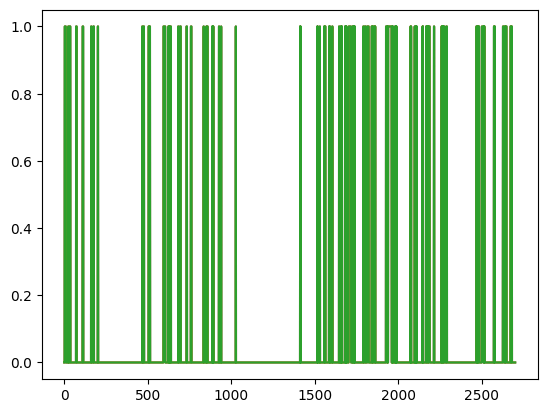

In [78]:
%matplotlib inline
plt.plot(np.array(logits[7] < 0).astype(int))
plt.show()

In [ ]:
logs = np.array([[x] * 25 for x in np.array(a < 0).astype(int)]).flatten()
ann = bool_to_annotations(logs, fps = 30)

In [185]:
ann

[[1.6668518518518518, 3.3337037037037036],
 [142.51583333333335, 143.34925925925927],
 [148.3498148148148, 149.18324074074073],
 [150.8500925925926, 155.01722222222222],
 [162.51805555555555, 165.01833333333335],
 [210.02333333333334, 210.85675925925926],
 [217.52416666666667, 222.52472222222224],
 [224.19157407407408, 225.025],
 [226.69185185185185, 227.52527777777777],
 [230.02555555555557, 230.8589814814815],
 [231.69240740740742, 235.0261111111111],
 [272.53027777777777, 275.03055555555557],
 [302.5336111111111, 308.3675925925926],
 [320.03555555555556, 321.7024074074074],
 [326.70296296296294, 330.8700925925926],
 [359.20657407407407, 362.54027777777776],
 [370.0411111111111, 370.87453703703704]]

In [103]:
2233 / 60

37.21666666666667

In [206]:
def fake_func(a = 'a', b = 'b'):
    return **kwargs

SyntaxError: invalid syntax (30395163.py, line 2)

In [205]:
fake_func()

NameError: name 'kwargs' is not defined

In [209]:
model_name =os.path.basename(checkpoint_dir)

In [212]:
import datetime
today = datetime.date.today().strftime('%m%d%y')
os.path.join('Fake/Path', model_name + "_" + today)

'Fake/Path/scratch_121824_011725'